In [1]:
import os
import numpy as np
from PIL import Image
import pybullet as p
import pybullet_data

OBJS_DIR = os.path.join('core', 'sim', 'objects')

Scene ID: 2183
Number of objects: 9
Grid size: [100, 100]


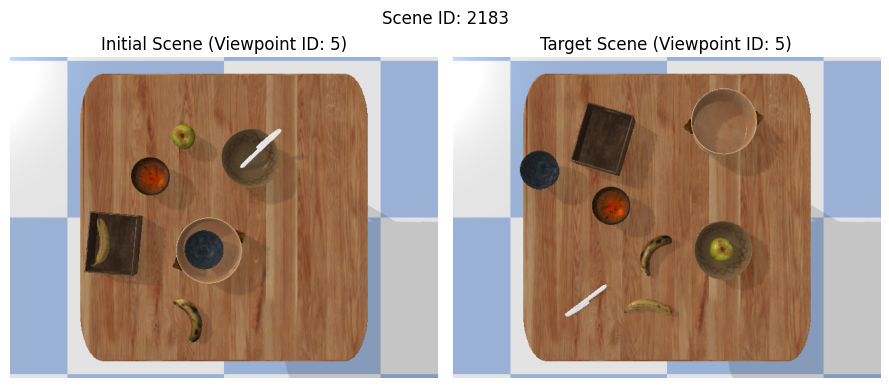

In [2]:
from core.env.scene_manager import SceneManager
from core.env.scene_utils import scene_meta_to_x
from core.sim.rearrangemet_loader import load_rearrangement_meta, visualize_rearrangement, select_rearrangement_dir

dataset_dir = "dataset-sim"

folder_path, scene_id = select_rearrangement_dir(dataset_dir, scene_id=None, viewpoint_id=5)
meta_data = load_rearrangement_meta(dataset_dir, scene_id=scene_id)

print(f"Scene ID: {meta_data.get('scene_id', 'Unknown')}")
print(f"Number of objects: {meta_data.get('num_objects', 'Unknown')}")
print(f"Grid size: {meta_data.get('grid_size', 'Unknown')}")

initial_x, target_x = scene_meta_to_x(meta_data)
env = SceneManager(
    num_objects=meta_data['num_objects'],
    grid_size=tuple(meta_data['grid_size']),
    verbose=0,
)
env.reset(initial_scene=initial_x, target_scene=target_x)
# env.render(fig_size=3)
visualize_rearrangement(dataset_dir, scene_id=scene_id)

# Different Viewpoints

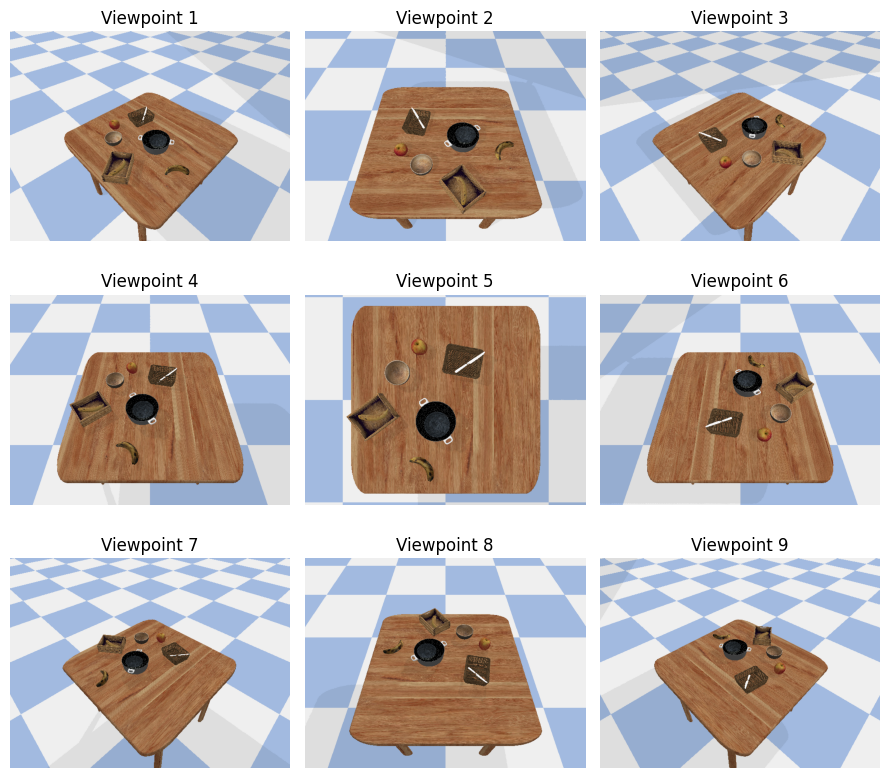

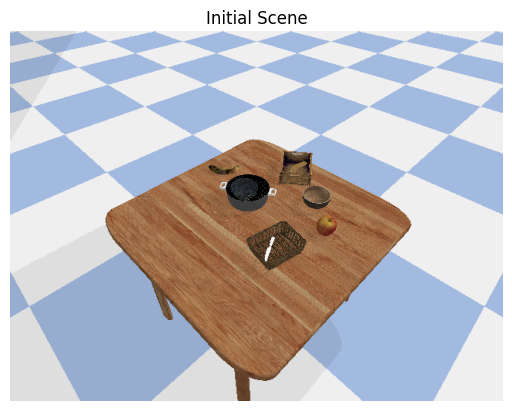

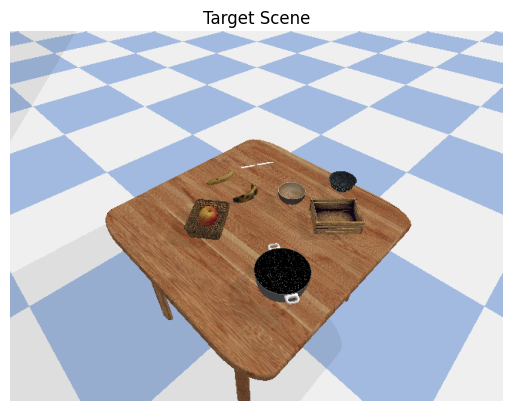

In [3]:
from core.sim.physics_utils import PyBulletSim, load_table_urdf, get_object_extents
from core.sim.camera_manager import CameraManager
import matplotlib.pyplot as plt
from core.sim.rearrangemet_loader import generate_scene_objects_from_meta, adjust_objects_for_scene

sim = PyBulletSim(p.DIRECT)
grid_size = tuple(meta_data['grid_size'])
table = load_table_urdf(OBJS_DIR, grid_size)
z = get_object_extents(table)[2]
cam = CameraManager()
cam.set_viewpoint(target_pos=[0, 0, z], viewpoint_id=8)

objects = generate_scene_objects_from_meta(
	OBJS_DIR, meta_data, z, grid_size=grid_size,
	target_mode=False,
)

sim.step(1)

fig, ax = plt.subplots(3, 3, figsize=(9, 9))
for i in range(9):
    cam.set_viewpoint(target_pos=[0, 0, z], viewpoint_id=i+1)
    ax[i//3, i%3].imshow(cam.capture_image())
    ax[i//3, i%3].set_title(f"Viewpoint {i+1}")
    ax[i//3, i%3].axis('off')
    plt.tight_layout()
plt.show()

cam.show_img(cam.capture_image(), title="Initial Scene")

objects = adjust_objects_for_scene(objects, meta_data, z, grid_size=grid_size, scene="target")
for obj in objects:
	orn = p.getQuaternionFromEuler(obj['final_orn'])
	p.resetBasePositionAndOrientation(obj['body_id'], obj['final_pos'], orn)

sim.step(1)

cam.show_img(cam.capture_image(), title="Target Scene")

sim.close()

# Tilt

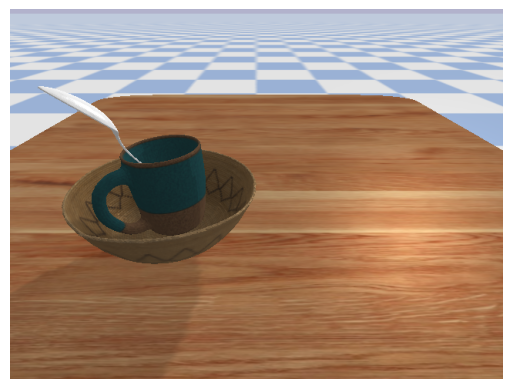

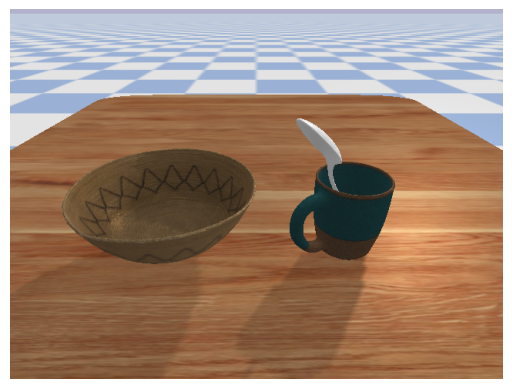

In [4]:
from core.sim.camera_manager import CameraManager
from core.sim.physics_utils import PyBulletSim, load_table_urdf, load_object_urdf, get_object_extents, apply_random_tilt

sim = PyBulletSim(p.GUI)
# sim = PyBulletSim(p.DIRECT)
cam = CameraManager(target_pos=[0, 0, z-0.1], distance=0.7, yaw=90, pitch=-30, roll=0)
table = load_table_urdf(OBJS_DIR, (100, 100))
z = get_object_extents(table)[2]
load_object_urdf(OBJS_DIR, 'basket', [0.3, -0.1, z+0.05], body_type=3, use_fixed_base=True)
# mug_orn = [0, 0, random.uniform(0, 2 * np.pi)]
mug_orn = [0, 0, np.pi/1.5]
mug = load_object_urdf(OBJS_DIR, 'mug',    [0.3, -0.1, z+0.1], mug_orn, body_type=3)[0]
pos, orn = [0.3, -0.1, z+0.2], [np.pi / 2, 0, 0]
pos, orn = apply_random_tilt(pos, orn, max_shift=0.01, tilt_angle=10)
spoon = load_object_urdf(OBJS_DIR, 'spoon',  pos, orn)[0]

sim.step(1)
cam.show_img(cam.capture_image())
p.removeBody(mug)
p.removeBody(spoon)
load_object_urdf(OBJS_DIR, 'mug',    [0.3, 0.1, z+0.08], mug_orn, body_type=3)
load_object_urdf(OBJS_DIR, 'spoon',  pos+[0, 0.2, 0], orn)
sim.step(1)
cam.show_img(cam.capture_image())
# sim.run()
sim.close()

# Calibration

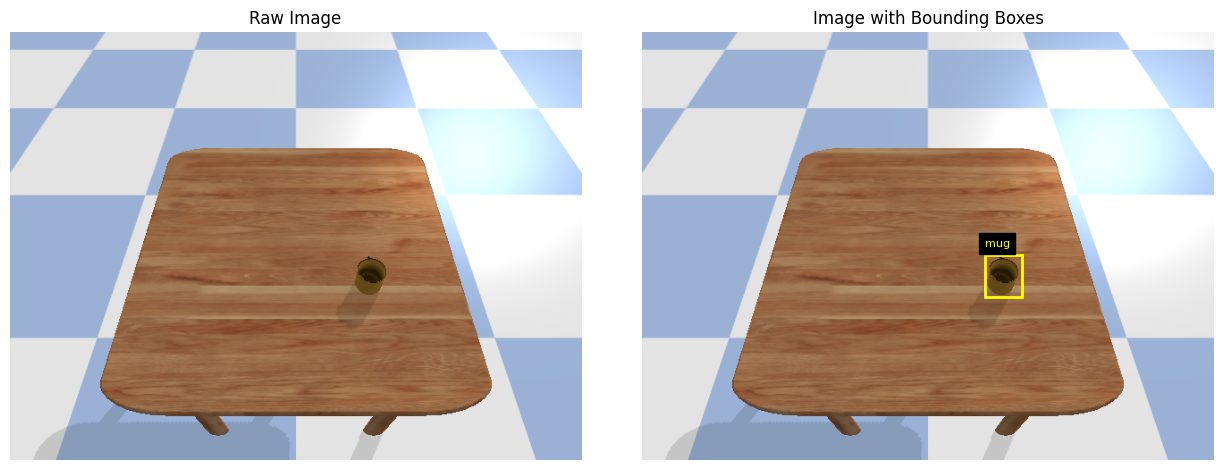


Sum of absolute differences: 0.00000030
Visualizing 3D markers (blue spheres) and 2D markers (red dots)...


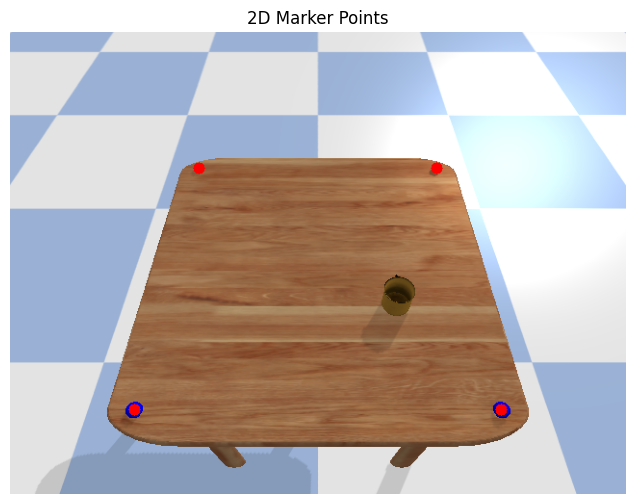

In [5]:
from core.sim.camera_manager import draw_markers
import random

def random_pos(x_range, y_range, z_range):
	return [
		random.uniform(*x_range),
		random.uniform(*y_range),
		random.uniform(*z_range)
	]

sim = PyBulletSim(p.GUI)
# sim = PyBulletSim(p.DIRECT)
table = load_table_urdf(OBJS_DIR, (100, 100))
z = get_object_extents(table)[2]
cam = CameraManager()
cam.set_viewpoint([0, 0, z], 8)

mug_id, mug_type = load_object_urdf(OBJS_DIR, 'mug', random_pos([-0.5, 0.5], [-0.5, 0.5], [z+0.05, z+0.05]))
sim.step(1)
bbox = cam.compute_2d_bounding_box(OBJS_DIR, 'mug', mug_id, mug_type)[0]
cam.draw_2d_bounding_boxes(cam.capture_image(), [bbox], ['mug'])
cam.draw_3d_bounding_box(bbox, n=np.array([0, 0, 1]), p0=np.array([0, 0, z+0.05]))

world_pts_test = np.array([
	[0.45, -0.45, z],
	[0.45,  0.45, z],
	[-0.45, 0.45, z],
	[-0.45,-0.45, z]
])
u, v = cam.project_world_to_pixel(world_pts_test)
image_pts_test = np.vstack([u, v]).T
cam.cal_parameters(world_pts_test, image_pts_test)
draw_markers(cam, world_pts_test, image_pts_test)

sim.run()